# We will use the C++ library, SimpleKalmanFilter (https://github.com/denyssene/SimpleKalmanFilter).
However, our first round of data was only raw data. As such, we need a way to create what the device we do when
it implements the filter onto the data that's fed in.

Note that this also uses the SimpleKalmanFilter.h folder which initializes the initial estimates and gain to 0.

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Define Kalman and do example

In [115]:
class SimpleKalmanFilter:
    def __init__(self, mea_e, est_e, q):
        self._err_measure = mea_e
        self._err_estimate = est_e
        self._q = q
        self._last_estimate = 0
        self._current_estimate = 0
        self._kalman_gain = 0

    def updateEstimate(self, mea):
        self._kalman_gain = self._err_estimate / (self._err_estimate + self._err_measure)
        self._current_estimate = self._last_estimate + self._kalman_gain * (mea - self._last_estimate)
        self._err_estimate = (1.0 - self._kalman_gain) * self._err_estimate + abs(self._last_estimate - self._current_estimate) * self._q
        self._last_estimate = self._current_estimate

        return self._current_estimate

    def setMeasurementError(self, mea_e):
        self._err_measure = mea_e

    def setEstimateError(self, est_e):
        self._err_estimate = est_e

    def setProcessNoise(self, q):
        self._q = q

    def getKalmanGain(self):
        return self._kalman_gain

    def getEstimateError(self):
        return self._err_estimate


In [116]:
def kalman_filter(data: list[float], e_mea: float, e_est: float, q: float) -> list[float]:
    kf = SimpleKalmanFilter(e_mea, e_est, q)
    filtered_data = []
    for measurement in data:
        filtered_value = kf.updateEstimate(measurement)
        filtered_data.append(filtered_value)
    return filtered_data

In [117]:
# Test
data = [1.0, 2.0, 3.0, 4.0, 5.0]

e_mea = 1.0
e_est = 1.0
q = 0.01

# Filter the data using the Kalman filter and print the filtered values.
filtered_data = kalman_filter(data, e_mea, e_est, q)
# print(filtered_data)

# Update our data_trail_1
Looks good! Lets take in our data_trail_1. For trial_4, we used the following kalman filters on the data as defined below in the C++ Code below:
```
SimpleKalmanFilter kalman_x1(0.05, 0.05, 0.008);
SimpleKalmanFilter kalman_x2(.1, .1, 0.008);
SimpleKalmanFilter kalman_x3(.1, .1, 0.5);
SimpleKalmanFilter kalman_x4(1, 1, 0.05);
SimpleKalmanFilter kalman_x5(10, 10, 0.08);
```
The parameters are 
```
e_mea =  // Amount to expect in noise
e_est =  // Set to e_mea as described by https://github.com/denyssene/SimpleKalmanFilter
float q = //  usually a small number between 0.001 and 1 how fast your measurement moves. Recommended 0.01. Should be tunned to your needs. (I think for this is equivalent to 1)
```

In [118]:
#Load in data:
raw_df = pd.read_csv("./Data/data_trial_1.csv")
x_axis = raw_df.iloc[:,0] # We only care about the x_axis
labels = raw_df.iloc[:,3][1980:6075]
x_axis = x_axis[1980:6075] 
data = x_axis.tolist()

In [119]:
#Define our set of parameters
params = [
    [0.05,0.05,0.008],
    [0.1,0.1,0.008],
    [0.1,0.1,0.5],
    [1,1,0.05],
    [10,10,0.08],
    [1,1,0.01]
] #different variations of e_mea, e_est, and q, see original arduino code for references
new_data = [] #stores our kalman filter values, index refers to the filter number as listed in description
for param_set in params:
    e_mea, e_est, q = param_set
    filtered_data = kalman_filter(data, e_mea, e_est, q)
    new_data.append(filtered_data)



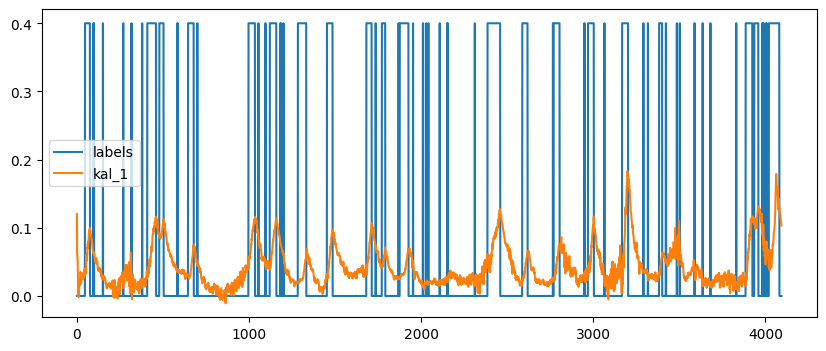

In [120]:
# Plot our results
labels = labels.tolist()
#size
plt.figure(figsize=(10,4))
# plt.plot(data, label = "x_raw")
plt.plot([x*0.4 for x in labels], label = "labels")
plt.plot(new_data[0], label = "kal_1")
# plt.plot(new_data[1], label = "kal_2")
# plt.plot(new_data[2], label = "kal_3")
# plt.plot(new_data[3], label = "kal_4")
# plt.plot(new_data[4], label = "kal_5")
# plt.plot(new_data[5], label = "kal_original")




plt.legend()
plt.show()


Looks good! Let's just filter the binary now:

In [121]:
def filtBreak(data,min_len):
    """
    This function takes in an 1D array or list of binary data and filters out cases where sequences of 1s
    are less than "min_len" 
    Inputs:
    - data (array or list):
    - min_len ()

    Ouputs:
    - filtered_data (np.array): filtered sequences
    """
    result = []
    count = 0

    for val in data:
        if val == 1:
            count += 1
        else:
            if count < min_len:
                result.extend([0] * count)
            else:
                result.extend([1] * count)
            result.append(val)
            count = 0

    if count < min_len:
        result.extend([0] * count)
    else:
        result.extend([1] * count)
    return result


# Define test inputs
test_data = np.array([1,1,1,0,0,1,0])
min_len = 3

# Define expected output
expected_output = np.array([1,1,1,0,0,0,0])

# Test the function
print(filtBreak(test_data,2))
assert(list(filtBreak(test_data,2))==list(expected_output))

# Print the results
print("Test passed!")
# 

[1, 1, 1, 0, 0, 0, 0]
Test passed!


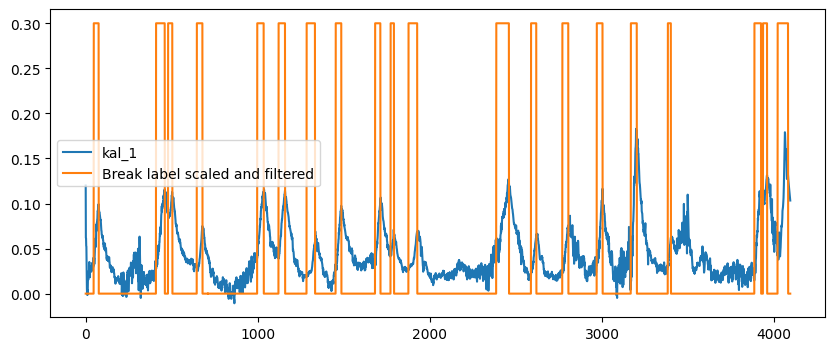

In [122]:
# FILTER our break
min_len = 4
break_bool_filt = filtBreak(list(labels),min_len)


plt.figure(figsize=(10,4))
plt.plot(new_data[0], label = "kal_1")
plt.plot([x*0.3 for x in list(break_bool_filt)],label = "Break label scaled and filtered")

plt.legend()
plt.show()

Finally, we need to shift our x values so they are 0 zeroed as the default resting acceleration measurement (x_axis value when device is at rest) will varry. 

In [123]:
#Get entire data:
raw_df = pd.read_csv("./Data/data_trial_1.csv")
x_raw = raw_df.iloc[:,0] # We only care about the x_axis
data = x_raw.tolist()
print("len data",len(data))



len data 6991


6991


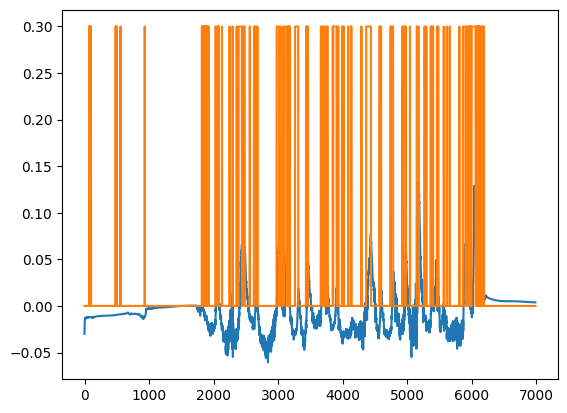

In [124]:

params = [
    [0.05,0.05,0.008],
    [0.1,0.1,0.008],
    [0.1,0.1,0.5],
    [1,1,0.05],
    [10,10,0.08],
    [1,1,0.01]
] #different variations of e_mea, e_est, and q, see original arduino code for references
new_data2 = [] #stores our kalman filter values, index refers to the filter number as listed in description
for param_set in params:
    e_mea, e_est, q = param_set
    filtered_data = kalman_filter(data, e_mea, e_est, q)
    new_data2.append(filtered_data)
print(len(new_data2[0]))
plt.plot([x-0.05 for x in new_data2[0]])
plt.plot([x*.3 for x in raw_df.iloc[:,3].tolist()])
# plt.plot(x_raw)
plt.show()

Looks like a shift of 0.05 down gets us to 0 ground! Let's apply that to the truncated and labeled filtered combination and take a look


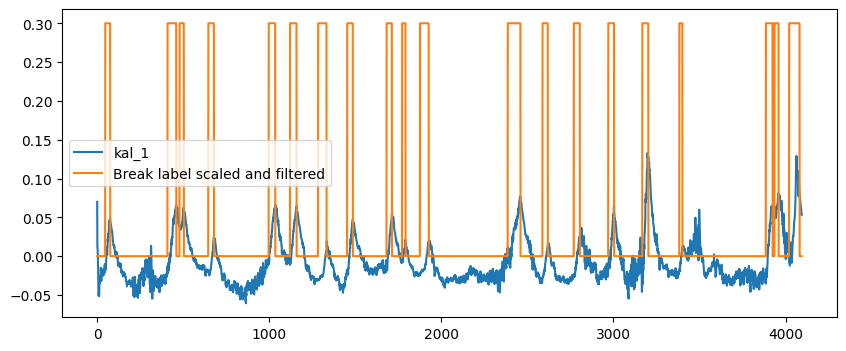

4095
4095


In [128]:
# FILTER our break
min_len = 4
break_bool_filt = filtBreak(list(labels),min_len)


plt.figure(figsize=(10,4))
plt.plot([x-0.05 for x in new_data[0]], label = "kal_1")
plt.plot([x*0.3 for x in list(break_bool_filt)],label = "Break label scaled and filtered")

plt.legend()
plt.show()
print(len([x-0.05 for x in list(new_data[0])]))
print(len([x*0.3 for x in list(break_bool_filt)]))

In [142]:
#Looks good! Let's save this
import os

directory = "./Data/train"

if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory", directory, "created.")
else:
    print("Directory", directory, "already exists.")

#Save data:
df_raw = {
    'x_kalhman_filter':[0 if x != x else x-0.05 for x in list(new_data[0])],
    'binary break label': [0 if x != x else int(x) for x in list(break_bool_filt)]
}
df = pd.DataFrame(data=df_raw)
df.to_csv('./Data/train/train_data1.5.csv')

Directory ./Data/train already exists.


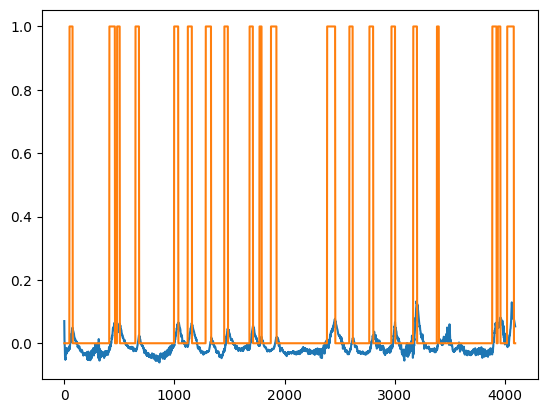

In [143]:
df = pd.read_csv('./Data/train/train_data1.5.csv')
plt.plot(df.iloc[:,1])
plt.plot(df.iloc[:,2])


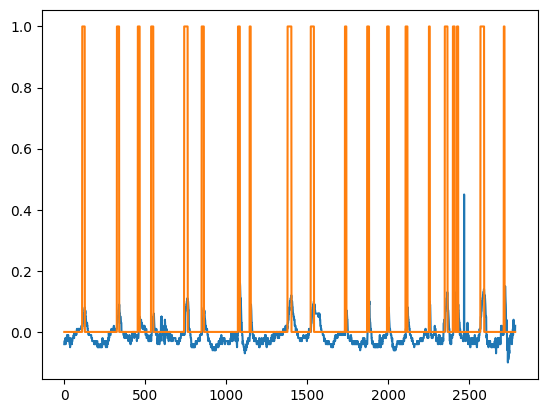

In [141]:
df = pd.read_csv('./Data/train/train_data4.csv')
plt.plot(df.iloc[:,1])
plt.plot(df.iloc[:,2])